# Lab : Iskay Quantum Optimizer - A Qiskit Function by Kipu Quantum

In this lab we will learn how to use the Iskay optimizer by Kipu Quantum in a practical and simple manner. We will need the basic tools explained during the first few lessons and labs of the QGSS.

Iskay leverages Kipu's cutting-edge BF-DCQO algorithm [[1](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.7.L022010),[2](https://doi.org/10.48550/arXiv.2409.04477)], to tackle unconstrained binary optimization problems. For example, in the commonly used Quadratic Unconstrained Binary Optimization (QUBO) formulation, as well as higher-order (HUBO). BF-DCQO is a non-variational quantum algorithm, which requires fewer computational resources than common variational algorithms, such as QAOA.

In Iskay, only the objective function is needed as input to automatically deliver problem solutions. It can handle optimization problems involving up to 156 qubits, enabling the use of all qubits of the IBM quantum devices. The Optimizer uses a 1-to-1 mapping between classical variables and qubits, which allows us to tackle optimization problems with up to 156 binary variables.

This lab is structure as follows

0. [Setup](#setup)
1. [Introduction](#introduction)  
    - [How does the Quantum Optimizer work?](#how_it_works)
    - [Workflow](#workflow)  
2. [Getting familiar with Iskay](#getting_familiar)
    * [Exercise 1a: Define problem graph](#exercise_1a)
    * [Exercise 1b: Extract the Ising fields](#exercise_1b)
    * [Exercise 1c/1d: Accessing Iskay](#exercise_1c)
    * [Exercise 1e: Retrieve and analyze results](#exercise_1e)
    * [Exercise 1f: Verifying optimality](#exercise_1f)
3. [HUBO problems](#hubo) 
    * [Exercise 2a: Find the challenging instance](#exercise_2a) 
    * [Exercise 2b: Characterizing the instance](#exercise_2b) 
    * [Exercise 2c: Solving it with Iskay](#exercise_2c)
4. [Concluding remarks](#conclusion)
---
<Admonition type="note">
  Qiskit Functions are an experimental feature available only to IBM Quantum™ Premium and Flex Plan users. They are in preview release status and subject to change.
</Admonition>

<a id="setup"></a>

## 0. Setup

In [1]:
# Install dependencies
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"
%pip install "qiskit[visualization]" qiskit-ibm-runtime qiskit-ibm-catalog networkx

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-q0r_cgk0/qc-grader_99aa604e76974a9ba19635d87c3264db
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-q0r_cgk0/qc-grader_99aa604e76974a9ba19635d87c3264db
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import qc_grader

print(f"Grader version: {qc_grader.__version__}")

Grader version: 0.22.12


You should have Grader `>=0.22.11`. If you see a lower version, you need to restart your kernel and reinstall the grader.

In [4]:
# Imports

import networkx as nx
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_catalog import QiskitFunctionsCatalog
from qiskit_ibm_runtime import QiskitRuntimeService
import time

from grader_iskay import (
    grade_lab_iskay_ex1a,
    grade_lab_iskay_ex1b,
    grade_lab_iskay_ex1c,
    grade_lab_iskay_ex1d,
    grade_lab_iskay_ex1e,
    grade_lab_iskay_ex2a,
    grade_lab_iskay_ex2b,
    grade_lab_iskay_ex2c
)

from qc_grader.challenges.qgss_2025 import grade_kipu_function

<div class="alert alert-block alert-warning">

**Exclusive Access to Qiskit Functions**

As part of Qiskit Global Summer School (QGSS), participants with a Premium or Flex Plan have limited-time trial access to Qiskit Functions. Access is exclusive and subject to your organization’s administrator approval. Complete [this form](https://airtable.com/appj8IrSNZGz4l4BB/pag8WgWdUr5uSJGZA/form) to request access.

If you encounter the error `QiskitServerlessException: Credentials couldn't be verified`. in the cell below, it means your access to Qiskit Functions is not yet active. Please check back later after your request has been processed.

**Note: Running this lab will consume QPU time from your organization’s account. Estimated QPU usage is provided before each cell that executes on a QPU. Please monitor your usage and consult your organization admin if you’re unsure about your allocated QPU time for QGSS Functions labs.**

</div>

In [5]:
# Load the Qiskit Functions Catalog
your_api_key = "deleteThisAndPasteYourAPIKeyHere"
your_crn = "deleteThisAndPasteYourCRNHere"

catalog = QiskitFunctionsCatalog(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
)
# You should see a list of Qiskit Functions available to you
# If you encounter the error `QiskitServerlessException: Credentials couldn't be verified`,
# it means your access is not yet active
catalog.list()

[QiskitFunction(qunova/hivqe-chemistry),
 QiskitFunction(global-data-quantum/quantum-portfolio-optimizer),
 QiskitFunction(algorithmiq/tem),
 QiskitFunction(qedma/qesem),
 QiskitFunction(multiverse/singularity),
 QiskitFunction(q-ctrl/optimization-solver),
 QiskitFunction(colibritd/quick-pde),
 QiskitFunction(q-ctrl/performance-management),
 QiskitFunction(kipu-quantum/iskay-quantum-optimizer)]

<div class="alert alert-block alert-success">
    
<b> Load Qiskit Function</b>

Find the correct function name from the list above, or refer to the [Qiskit Functions Catalog](https://quantum.cloud.ibm.com/functions) to locate the appropriate function name string. The name should follow the format: `"[provider]/[title]"`.

</div>

In [6]:
# Load Kipu Iskay Quantum Optimizer function

function_name = "kipu-quantum/iskay-quantum-optimizer"  # TODO
optimizer = catalog.load(function_name)

In [7]:
grade_kipu_function(optimizer)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<a id="introduction"></a>

## 1. Introduction

The Optimizer is a ready-to-use implementation of cutting-edge quantum optimization algorithms. It solves optimization problems by running highly-compressed quantum circuits on quantum hardware. This compression is achieved by introducing **counterdiabatic** terms into the underlying time evolution of the quantum system. The algorithm executes several iterations of hardware runs to obtain the final solutions and combines it with post-processing. These steps are seamlessly integrated into the Optimizer's workflow and are executed automatically.

![Workflow](https://docs.quantum.ibm.com/images/guides/kipu-optimization/workflow.svg "Workflow of the Quantum Optimizer")

<a id="how_it_works"></a>
### 1.1 How does the Quantum Optimizer work?
This section outlines the basics of the implemented BF-DCQO algorithm. An introduction to the algorithm can also be found on the [Qiskit YouTube channel.](https://www.youtube.com/watch?v=33QmsXhIlpU&t=1223s)

The algorithm is based on the time evolution of a quantum system which is transformed over time, where the problem solution is encoded in the ground state of the quantum system at the end of the evolution. According to the [adiabatic theorem](https://en.wikipedia.org/wiki/Adiabatic_theorem), this evolution has to be slow to ensure the system remains in its ground state. Digitizing this evolution is the basis of digitized quantum adiabatic computation (DQA) and the infamous QAOA algorithm. However, the required slow evolution is not feasible for increasing problem sizes since it results in an increasing circuit depth. By using counterdiabatic protocols, we can suppress unwanted excitations occurring during short evolution times while remaining in the ground state. Here, digitizing this shorter evolution time results in quantum circuits with shorter depth and fewer entangling gates.

The circuits of the BF-DCQO algorithms typically use up to ten times fewer entangling gates than DQA, and three to four times fewer entangling gates than standard QAOA implementations. Because of the smaller number of gates, fewer errors occur during the circuit execution on hardware. Hence, the optimizer does not require using techniques like error suppression or error mitigation. Implementing them in future versions can enhance the solution quality even further.

Although the BF-DCQO algorithm uses iterations, it is non-variational. After each iteration of the algorithm, the distribution of states is measured. The obtained distribution is used to calculate a so-called bias-field. The bias-field allows starting the next iteration from an energy state near the previously found solution. In this way, the algorithm moves with each iteration to solutions of lower energy. Typically, approximately ten iterations are sufficient to converge to a solution, in total requiring a much lower number of iterations than variational algorithms, which is on the order of  approximately 100 iterations.

The optimizer combines the BF-DCQO algorithm with classical post-processing. After measuring the distribution of states, a local search is performed. During the local search, the bits of the measured solution are randomly flipped. After the flip, the energy of the new bitstring is evaluated. If the energy is lower, the bitstring is kept as the new solution. The local search only scales linearly with the number of qubits; hence, it is computationally cheap. Since the post-processing corrects local bitflips, it compensates for bit-flip errors that often are the result of hardware imperfections and readout errors.

<a id="workflow"></a>
### 1.2 Workflow

A schematic of the workflow of the Quantum Optimizer follows.

By using the Quantum Optimizer, solving an optimization problem on quantum hardware can be reduced to
* Formulate the objective function of the problem
* Access the Optimizer via Qiskit Functions
* Run the Optimizer and collect the result



<a id="getting_familiar"></a>

## 2. Getting familiar with Iskay

First, we will tackle Max-Cut, a problem we already know from the first week of QGSS. In simple words, the Max-Cut problem asks: given a graph, how can we partition its vertices into two sets so that the total weight of edges between the sets is as large as possible? The problem is NP-hard in general.

<a id="exercise_1a"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1a: Define problem graph</b> 

**Your Goal:** Build a graph that represents the combinatorial optimization problem

In this exercise you must create a 50 qubit 3-regular graph. You can take as template the labs from the first week. Use the ```networkx.random_regular_graph``` function

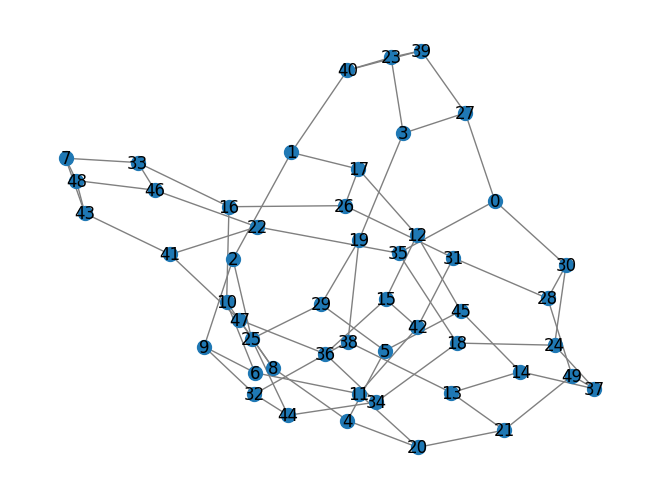

In [16]:
# Create a random 3-regular graph. Do not change the seed or number of nodes.
seed = 0
num_nodes = 50

# ---- TODO : Task 1 ---
# Use NetworkX to create a random 3-regular graph with the specified number of nodes and seed.
graph = nx.random_regular_graph(3,num_nodes, seed=seed)

# --- End of TODO ---

nx.draw(
    graph,
    with_labels=True,
    edge_color='gray',
    node_size=100
)

In [17]:
grade_lab_iskay_ex1a(graph)


Congratulations 🎉! Your answer is correct.


<a id="exercise_1b"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1b: Extract the Ising fields </b> 

**Your Goal:** Build the dictionary of the Ising fields, which represent the objective function. Use 0.5 as the coupling stengths.

In this exercise you must obtain a dictionary of tuples and coefficients, which represents the problem. For example, 

```python  
'(0,)': 1.5,
'(1,)': 2,
'(2,)': 1.3,
'(0, 3)': 2.5,
'(1, 4)': 3.5,
```  

represents a graph of five nodes, where nodes 0,1,2 have specific weights and both (0,3) and (1,4) are connected. Note that these fields can also be used to easily build the Hamiltonian.


In [26]:
# Create the objective function for MaxCut in Ising formulation
def graph_to_ising_maxcut(graph):
    # Initialize the linear and quadratic coefficients
    objective_func = {}

    # ---- TODO : Task 2 ---
    for i, j in graph.edges():
        key = f"({i}, {j})"
        objective_func[key] = 0.5
    # --- End of TODO ---
    
    return objective_func

objective_func = graph_to_ising_maxcut(graph)

In [27]:
grade_lab_iskay_ex1b(objective_func, graph)


Congratulations 🎉! Your answer is correct.


<a id="exercise_1c"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1c: Accessing Iskay </b> 

**Your Goal:** Solve the problem using Iskay

In this exercise you must
- Get the name of the least busy backend
- Create a job 

In [29]:
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
)

# ---- TODO : Task 3 ---
least_busy_backend = service.least_busy(operational=True)
least_busy_backend_name = least_busy_backend.name 
# --- End of TODO ---

print(f"Least busy backend: {least_busy_backend_name}")

Least busy backend: ibm_fez


We are going to do 10 iterations with 2500 shots each. This gives a total of 25000 shots. 

In [ ]:
# Setup options to run the optimizer
options = {"shots": 2_500, "num_iterations": 10, "use_session": True}

# ---- TODO : Task 4 ---
# Prepare the arguments for the optimizer
arguments = {
    'problem': objective_func,
    'problem_type': "spin",
    'instance': "MYCRN",
    'backend_name': least_busy_backend_name,
    'options': options,
}
# --- End of TODO ---

In [41]:
grade_lab_iskay_ex1c(arguments)


Congratulations 🎉! Your answer is correct.


<div class="alert alert-block alert-warning">

**⚠️ Warning: QPU Time Consumption**

Running the cell below will submit a job to a QPU and consume real QPU time. Please ensure you intend to proceed.

**Estimated QPU runtime:** 2 minutes 35 seconds (based on tests on `ibm_brussels`)

</div>

In [42]:
# Run the optimizer
job = optimizer.run(**arguments)
job_id = job.job_id

print(f"Job ID: {job_id}")

Job ID: b7d6e3d7-f18b-4279-af60-2f49dd8d48b7


<a id="exercise_1d"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1d: Retrieve and analyze results </b> 

**Your Goal:** Understand the structure from the results and plot the optimal solution found

In this exercise you must
- Use the job id to retrieve the results. The status of the task can be checked with ```job.status()```
- Get the max-cut solution bitstring as well as its cost

In [50]:
# Load the job from the job ID
# job = catalog.job(job_id)

while True:
    print(f"Waiting for job {job_id} to complete... (status: {job.status()})",  end='\r', flush=True)
    if job.status() in ['DONE', 'CANCELED', 'ERROR']:
        print(f"Job {job_id} completed with status: {job.status()}")
        break
    time.sleep(30)

Job b7d6e3d7-f18b-4279-af60-2f49dd8d48b7 completed with status: DONE(status: DONE)


In [48]:
error_message = job.error_message()
print(error_message)

In [57]:
# Retrieve the results
# ---- TODO : Task 5 ---
result = job.result()
maxcut_solution = result["solution"]
cost = result.get("cost")
# --- End of TODO ---

print("Max-Cut solution:", maxcut_solution)

Max-Cut solution: {'0': -1, '1': -1, '2': 1, '3': -1, '4': -1, '5': 1, '6': 1, '7': 1, '8': 1, '9': -1, '10': -1, '11': -1, '12': 1, '13': 1, '14': 1, '15': -1, '16': 1, '17': 1, '18': -1, '19': 1, '20': 1, '21': -1, '22': -1, '23': 1, '24': 1, '25': 1, '26': -1, '27': 1, '28': -1, '29': -1, '30': 1, '31': 1, '32': 1, '33': -1, '34': 1, '35': 1, '36': 1, '37': -1, '38': -1, '39': -1, '40': 1, '41': 1, '42': 1, '43': -1, '44': -1, '45': -1, '46': 1, '47': -1, '48': -1, '49': 1}


The solution dictionary indicates the orientation of each qubits. In terms of the graph, it indicates the bipartition: all nodes pointing up (+1) are part of one partition, whereas the ones point down (-1) are part of the other partition. Since the goal of the max-cut problem is to increate the number of connections between these two partitions, we can nicely visualize it. But first, let's check that the cost to the associated Hamiltonian is the right one.

In [58]:
grade_lab_iskay_ex1d(result)

Obtained cost -29.5 matches expected optimal cost -29.5. 

Congratulations 🎉! Your answer is correct.


Use the following code to plot the solution obtained from hardware using BF-DCQO

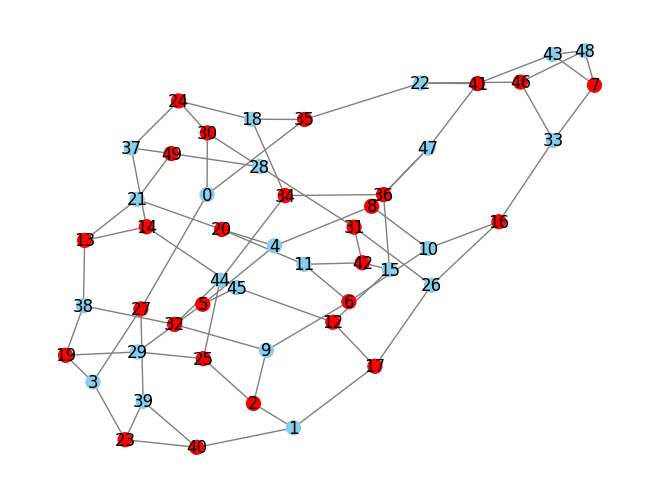

In [ ]:
# Choose which nodes to highlight
special_nodes = {int(node) for node, s in maxcut_solution.items() if s == 1}

# Build a list of colors, one per node, in graph.nodes() order
color_map = []
for node in graph.nodes():
    if node in special_nodes:
        color_map.append('red')
    else:
        color_map.append('skyblue')

# Draw, passing the color list
nx.draw(
    graph,
    with_labels=True,
    node_color=color_map,
    edge_color='gray',
    node_size=100
)

<a id="exercise_1e"></a>
<div class="alert alert-block alert-success">
    
<b>[Optional] Exercise 1e: Verifying optimality </b> 

**Your Goal:** Find the cut value and check the optimality of the obtained solution

In this exercise you must
- Use the graph to find the cut value, i.e. how many edges are connecting the two partitions
- Verify optimality of the obtained solution. 

<div class="alert alert-block alert-warning">
<b> ⚠️ Warning: Problem beyond brute force</b>

Despite this is an example problem of relatively small size (50 qubits), it is already beyond brute force approach. Therefore, do not search all possible combinations. Instead, rely on heuristics or exact solvers.

</div>

In [ ]:
# Calculate the cut value

def cut_value(graph: nx.Graph, x: dict) -> int:

    # ---- TODO : Task 6 ---
    return sum(1 for i, j in graph.edges() if x[str(i)] != x[str(j)])
    # --- End of TODO ---


cut = cut_value(graph, maxcut_solution)

In [67]:
grade_lab_iskay_ex1e(cut)


Congratulations 🎉! Your answer is correct.


Now we can verify the optimality of the solution. This part is free and will not be graded. Are you able to verify the solution without brute-force?
<div class="alert alert-info">
<details>
    <summary> <b>Hint</b> 💡: (Click to expand)</summary>
    Check qiskit optimization at https://qiskit-community.github.io/qiskit-optimization/
</details>
</div>

## 3. HUBO problems 

Higher order binary unconstrained optimization (HUBO) problems extend the familiar QUBO problems by allowing objective functions to include terms that involve interactions among three or more binary variables. Formally, a HUBO problem aims to optimize the cost function

$$
f(x) = \sum_i a_i x_i + \sum_{i<j} b_{ij} x_i x_j + \sum_{i<j<k} c_{ijk} x_i x_j x_k + \dots
$$

with binary variables $x_i \in \{0,1\}$. The higher order couplings $c_{ijk\cdots}$ introduce a new layer of complexity to the problem, which typically results in landscapes that are harder to navigate due to increades ruggedness. 

Higher-order interactions arise naturally in many industrial settings. For example, a possible formulation of the protein folding problem requires up to 5-local couplings, meaning that there are terms of the type $c_{ijklm}  x_i x_j x_k x_l x_m$. Another key benchmark example is the Max-k-SAT problem, which includes up to k-local couplings, as well as the dynamical portfolio optimization admits a HUBO formulation as well. 

HUBO problems may be challenging for classical solvers since many of them require classical reduction techniques, i.e. converting higher-order terms into quadratic ones by introducing auxiliary variables and penalty terms. While this maps a HUBO to a QUBO, it typically increases problem size proportional to the number of higher-order interactions and requires delicate tuning of penalty strengths.

In this lab, your goal is to add a datapoint to an existing public benchmark. To do this, you will need to determine which problem from this public benchmark is worth tackling with Iskay. 

<a id="exercise_2a"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 2a: Find the challenging instance </b> 

**Your Goal:** Search for the challenging HUBO instance and provide the index

In this exercise you must go to [this paper](https://www.nature.com/articles/s41534-024-00825-w) and find the challenging instance, where no quantum algorithm could find the optimal solution. 


</div>

<div class="alert alert-info">
<details>
    <summary> <b>Hint</b> 💡: (Click to expand)</summary>
    See Table 4 
</details>
</div>

In [68]:
# Find the index of the challenging instance
# ---- TODO : Task 7 ---
idx = 5
# --- End of TODO ---

In [69]:
grade_lab_iskay_ex2a(idx)


Congratulations 🎉! Your answer is correct.


<a id="exercise_2b"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 2b: Characterizing the instance </b> 

**Your Goal:** Check the amount of Hamiltonian terms and their locality

In this exercise you must provide how many one-, two-, and three-local terms are present in the Hamiltonian (cost function). 

In [72]:
# Load the instance as an objective function 

with open(f'data/ibm_washington.txt', 'r') as file:
    content = file.read()

objective_func = {}

for list_of_fields in eval(content):
    for field in list_of_fields:
        for key,val in field.items():
            if isinstance(key, tuple):
                objective_func[str(tuple(sorted(key)))] = val
            elif isinstance(key, int):
                objective_func[str((key,))] = val


# ---- TODO : Task 8 ---
one_local_terms = sum(1 for key in objective_func.keys() if len(eval(key)) == 1)
two_local_terms = sum(1 for key in objective_func.keys() if len(eval(key)) == 2)
three_local_terms = sum(1 for key in objective_func.keys() if len(eval(key)) == 3)
# --- End of TODO ---

print(f"One-local terms: {one_local_terms}")
print(f"Two-local terms: {two_local_terms}")
print(f"Three-local terms: {three_local_terms}")

One-local terms: 127
Two-local terms: 142
Three-local terms: 69


In [73]:
grade_lab_iskay_ex2b(one_local_terms, two_local_terms, three_local_terms)


Congratulations 🎉! Your answer is correct.


<a id="exercise_2c"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 2c: Solving it with Iskay </b> 

**Your Goal:** Use the Iskay optimizer to tackle this instance

Particularly, set the parameters
- shots per iteration : 10000
- number of iterations : 10
- problem type : spin
- backend : Use the best backend available in your plan for better results. 

In [ ]:
# Setup options to run the optimizer
options = {"shots": 10_000, "num_iterations": 10, "use_session": True}

# ---- TODO : Task 9 ---
# Prepare the arguments for the optimizer
arguments = {
    'problem': objective_func,
    'problem_type': "spin",
    'instance': "MYCRN",
    'backend_name': least_busy_backend_name,
    'options': options,
}
# --- End of TODO ---

In [75]:
grade_lab_iskay_ex2c(arguments)


Congratulations 🎉! Your answer is correct.


<div class="alert alert-block alert-warning">

**⚠️ Warning: QPU Time Consumption**

Running the cell below will submit a job to a QPU and consume real QPU time. Please ensure you intend to proceed.

**Estimated QPU runtime:** 7 minutes 1 seconds (based on tests on `ibm_brussles`)

</div>

In [76]:
# Run the optimizer

# ---- TODO : Task 10 ---
job = optimizer.run(**arguments)
job_id = job.job_id
# --- End of TODO ---

print(f"Job ID: {job_id}")

Job ID: 6193e173-b0cb-4a64-8773-096e39cfa478


In [78]:
# Load the job from the job ID 
# job = catalog.job(job_id)

while True:
    print(f"Waiting for job {job_id} to complete... (status: {job.status()})",  end='\r', flush=True)
    if job.status() in ['DONE', 'CANCELED', 'ERROR']:
        print(f"Job {job_id} completed with status: {job.status()}")
        break
    time.sleep(30)

Job 6193e173-b0cb-4a64-8773-096e39cfa478 completed with status: DONE(status: DONE)NG)
Job 6193e173-b0cb-4a64-8773-096e39cfa478 completed with status: DONE


In [79]:
cost = job.result()["solution_info"]["cost"]
print("Obtained best cost:", cost)

Obtained best cost: -198


How do your results compare to this small benchmark? Add a new column with your results! The obtained results depend on the Hardware used. Here we also include our internal test on different IBM devices, compared to the ones from Table 4 from the reference paper. 

|  | Reference | Iskay (IBM Torino) | Iskay (IBM Fez) | Iskay (IBM Marrakesh) | Quantum Annealing | QAOA | Iskay (QGSS lab)
|----------|----------|----------|----------|----------|----------|----------|----------|
| Energy   |  -198    |  -194    | -196     | -198     | -194     | -128     |  -198    | 


<a id="conclusion"></a>

# 4. Concluding remarks

Congratulations that you have made it to this point of the lab. 

We have learned how to use Iskay Optimizer at the basic level and even tackle slightly challenging problems. Iskay optimizer is based on BF-DCQO, which is an algorithm developed by Kipu Quantum to tackle unconstrained binary optimization problems. This algortihm has been fine tuned as a problem- and hardware- specific method, such that it has shown evidence of [runtime advantage](https://arxiv.org/abs/2505.08663) with respect to specific classical solvers. Additionally, it has been [tested on all-to-all](https://arxiv.org/abs/2506.07866) connected quantum devices as well as [combined with analog devices](https://arxiv.org/abs/2506.20655), such as quantum annealers. As next steps, we encourage you to test other types of problems and give us feedback through Discord.

# Feedback Survey

We’d love to hear about your experience using the Qiskit Function! Your feedback is valuable and will help Qiskit Function providers enhance their tools and services. Please take a moment to share your thoughts by completing our short 2 min [feedback survey](https://airtable.com/app6VujlNUHZuOnAF/pagpw6TgP9UEt4TAT/form).

# References

[1] Cadavid AG, Dalal A, Simen A, Solano E, Hegade NN. Bias-field Digitized Counterdiabatic Quantum Optimization. Phys. Rev. Research <a href="https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.7.L022010">7:L022010</a>. 2025 Apr 9.

[2] Romero SV, Visuri AM, Cadavid AG, Solano E, Hegade NN. Bias-Field Digitized Counterdiabatic Quantum Algorithm for Higher-Order Binary Optimization. arXiv preprint <a href="https://arxiv.org/abs/2409.04477">arXiv:2409.04477</a>. 2024 Sep 5.

[3] Chandarana P, Cadavid AG, Romero SV, Simen A, Solano E, Hegade NN. Runtime Quantum Advantage with Digital Quantum Optimization. arXiv preprint <a href="https://arxiv.org/abs/2505.08663">arXiv:2505.08663</a>. 2025 May 13.

[4] Romero SV, Cadavid AG, Solano E, Hegade NN. Sequential Quantum Computing. arXiv preprint <a href="https://arxiv.org/abs/2506.20655">arXiv:2506.20655</a>. 2025 Jun 25.


# Additional information

**Created by:** Alejandro Gomez Cadavid

**Advised by:** Junye Huang

**Version:** 1.1.0

In [80]:
import qiskit
import qiskit_ibm_runtime
import qiskit_ibm_catalog

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Qiskit IBM Catalog: {qiskit_ibm_catalog.__version__}')

Qiskit: 2.1.1
Qiskit IBM Runtime: 0.40.1
Qiskit IBM Catalog: 0.8.0
